### **Import Library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf # Untuk mengatur seed demi reproducibility
import plotly.express as px
import matplotlib.pyplot as plt


### **Import Data Hasil Rules**

In [2]:
df = pd.read_csv('D:/kuliah/PA/sakinah-mart/data/rules2023.csv')
df.head()

,Unnamed: 0,antecedents,consequents,support,confidence,lift
0,0,"frozenset({'HARMONY MELON', 'HARMONY LEMON', '...",frozenset({'HARMONY STRAWBERY'}),0.000113,1,1235.260000
1,1,"frozenset({'DELFI TOP TRIP/CHO 9GR', 'MOMOGI J...",frozenset({'MOMOGI CKL 6GR'}),0.000113,1,686.255556
2,2,"frozenset({'INDOMILK KID VNL 115ML', 'CLOUD 9 ...",frozenset({'CLOUD 9 CHOCO 15 4G'}),0.000113,1,571.879630
3,3,"frozenset({'CLOUD 9 VANILA 15 4G', 'INDOMILK K...",frozenset({'CLOUD 9 CHOCO 15 4G'}),0.000146,1,571.879630
4,4,"frozenset({'INDOMILK KID VNL 115ML', 'CLOUD 9 ...",frozenset({'CLOUD 9 CHOCO 15 4G'}),0.000146,1,571.879630


In [3]:
# Pastikan semua elemen dalam kolom antecedents dan consequents adalah frozenset
df["antecedents"] = df["antecedents"].apply(lambda x: frozenset(eval(x)) if isinstance(x, str) else x)
df["consequents"] = df["consequents"].apply(lambda x: frozenset(eval(x)) if isinstance(x, str) else x)

# Mengambil semua item unik
all_items = set()
for col in ["antecedents", "consequents"]:
    for items in df[col]:
        all_items.update(items)

all_items

{'BIG BLUEBRRY 375ML',
 'CIPTADENT PG FRS 190ML',
 'CLOUD 9 CHOCO 15 4G',
 'CLOUD 9 VANILA 15 4G',
 'DELFI TOP TRIP/CHO 9GR',
 'EKONOMI E900K',
 'HARMONY LEMON',
 'HARMONY MELON',
 'HARMONY ORANGE',
 'HARMONY STRAWBERY',
 'HERS PROT SCM 60 S',
 'INDOMIE AYAM BAWANG',
 'INDOMIE AYAM SPECIAL',
 'INDOMIE GRG SPECIAL',
 'INDOMIE SOTO MIE',
 'INDOMILK KID CKL 115ML',
 'INDOMILK KID STR 115ML',
 'INDOMILK KID VNL 115ML',
 'INDOMILK STR 190ML BTL',
 'KRIPIK SGKG TURBO 180G',
 'MOMOGI CKL 6GR',
 'MOMOGI JGG BKR 6GR',
 'NUVO SOAP BLUE 72G',
 'NUVO SOAP YLOW 72G',
 'OREO SOFT CAKE 16GR',
 'PARAMEX SKT KEPALA',
 'PUCUK HARUM TEH 350ML',
 'ROMA KELAPA 300GR',
 'SUNSILK SHP BLK SHN 160ML',
 'TEH GELAS ORI 170ML',
 'TONGTJI JASMINE 5 S',
 'TWISTER MINI CPP 20GR',
 'WAFELLO COCONUT 37 5G',
 'WALLS POPULAIRE STR',
 'YA KOPI SPESIAL 60GR'}

### **Import Data Transaksi**

In [4]:
groceries = pd.read_excel('D:/kuliah/PA/sakinah-mart/data/final_data2023.xlsx')
groceries

,TANGGAL,NO TRANSAKSI,NAMA BARANG,QTY
0,2023-01-01,2301011000001,FORVITA MARG 200GR,2
1,2023-01-01,2301011000002,SASA SANTAN KLPA 65ML,3
2,2023-01-01,2301011000003,CHEERS 1500ML GREEN,1
3,2023-01-01,2301011000004,SUN KARA 65ML,1
4,2023-01-01,2301011000004,OREO PIKACHU 165 6GR,1
...,...,...,...,...
162975,2023-12-31,2312311020112,KONIDIN 4 S,2
162976,2023-12-31,2312311020113,GOLDA CAPPUCINO 200ML,1
162977,2023-12-31,2312311020113,FLORIDINA ORANGE 360ML,1
162978,2023-12-31,2312311020114,WALLS PP TRICO/48,1


### **Filter Data Transaksi**

In [5]:
df_filtered = groceries[groceries['NAMA BARANG'].isin(all_items)]
df_filtered 

,TANGGAL,NO TRANSAKSI,NAMA BARANG,QTY
9,2023-01-01,2301011000008,OREO SOFT CAKE 16GR,2
34,2023-01-01,2301011000018,PUCUK HARUM TEH 350ML,6
62,2023-01-01,2301011000034,ROMA KELAPA 300GR,1
96,2023-01-01,2301011000040,INDOMIE AYAM BAWANG,1
100,2023-01-01,2301011000041,YA KOPI SPESIAL 60GR,1
...,...,...,...,...
162895,2023-12-31,2312311020095,INDOMIE GRG SPECIAL,4
162902,2023-12-31,2312311020096,INDOMIE GRG SPECIAL,4
162944,2023-12-31,2312311020102,INDOMIE GRG SPECIAL,2
162946,2023-12-31,2312311020102,INDOMIE SOTO MIE,2


In [6]:
# Menampilkan jumlah unik nama barang
jumlah_nama_barang = df_filtered['NAMA BARANG'].nunique()
print("Jumlah nama barang unik:", jumlah_nama_barang)

# Menampilkan isi nama barang yang unik
nama_barang_unik = df_filtered['NAMA BARANG'].unique()
print("Nama barang unik:")
for nama in nama_barang_unik:
    print("-", nama)

Jumlah nama barang unik: 35
Nama barang unik:
- OREO SOFT CAKE 16GR
- PUCUK HARUM TEH 350ML
- ROMA KELAPA 300GR
- INDOMIE AYAM BAWANG
- YA KOPI SPESIAL 60GR
- INDOMILK KID CKL 115ML
- INDOMILK STR 190ML BTL
- EKONOMI E900K
- INDOMILK KID STR 115ML
- TWISTER MINI CPP 20GR
- INDOMIE GRG SPECIAL
- INDOMIE AYAM SPECIAL
- WALLS POPULAIRE STR
- MOMOGI CKL 6GR
- HARMONY ORANGE
- HARMONY LEMON
- NUVO SOAP BLUE 72G
- NUVO SOAP YLOW 72G
- TONGTJI JASMINE 5 S
- INDOMIE SOTO MIE
- MOMOGI JGG BKR 6GR
- PARAMEX SKT KEPALA
- KRIPIK SGKG TURBO 180G
- SUNSILK SHP BLK SHN 160ML
- BIG BLUEBRRY 375ML
- HARMONY STRAWBERY
- HERS PROT SCM 60 S
- TEH GELAS ORI 170ML
- DELFI TOP TRIP/CHO 9GR
- CLOUD 9 CHOCO 15 4G
- CLOUD 9 VANILA 15 4G
- HARMONY MELON
- CIPTADENT PG FRS 190ML
- WAFELLO COCONUT 37 5G
- INDOMILK KID VNL 115ML


### **Agregasi Data Mingguan**

In [7]:
# Agregasi jumlah QTY per tanggal dan nama barang
df_grouped = df_filtered.groupby(['TANGGAL', 'NAMA BARANG'], as_index=False)['QTY'].sum()

tanggal_range = pd.date_range(start='2023-01-01', end='2023-12-31')
all_items = df_filtered['NAMA BARANG'].unique()

# Buat kombinasi semua tanggal dan item
multi_index = pd.MultiIndex.from_product([tanggal_range, all_items], names=['TANGGAL', 'NAMA BARANG'])
all_combinations = pd.DataFrame(index=multi_index).reset_index()

# Gabungkan dengan hasil groupby
df_joined = pd.merge(all_combinations, df_grouped, on=['TANGGAL', 'NAMA BARANG'], how='left')
df_joined['QTY'] = df_joined['QTY'].fillna(0)

# Pastikan TANGGAL dalam datetime
df_joined['TANGGAL'] = pd.to_datetime(df_joined['TANGGAL'])

# Urutkan dulu datanya
df_joined = df_joined.sort_values('TANGGAL')

# Ambil tanggal paling awal
start_date = df_joined['TANGGAL'].min()

# Hitung minggu ke-n secara manual (tiap 7 hari)
df_joined['WEEK_NUMBER'] = ((df_joined['TANGGAL'] - start_date).dt.days // 7) + 1

# Agregasi berdasarkan minggu dan nama barang
df_weekly = df_joined.groupby(['WEEK_NUMBER', 'NAMA BARANG'], as_index=False)['QTY'].sum()

# (Opsional) Tambahkan kolom tanggal mulai minggu
df_weekly['TANGGAL'] = start_date + pd.to_timedelta((df_weekly['WEEK_NUMBER'] - 1) * 7, unit='D')

# Visualisasi
fig = px.line(df_weekly, x='TANGGAL', y='QTY', color='NAMA BARANG',
              title='Jumlah Penjualan per Minggu (Setiap 7 Hari)')
fig.update_layout(legend_title_text='Klik untuk tampilkan/sembunyikan item')
fig.show()

In [8]:
df_weekly

,WEEK_NUMBER,NAMA BARANG,QTY,TANGGAL
0,1,BIG BLUEBRRY 375ML,1.0,2023-01-01
1,1,CIPTADENT PG FRS 190ML,0.0,2023-01-01
2,1,CLOUD 9 CHOCO 15 4G,0.0,2023-01-01
3,1,CLOUD 9 VANILA 15 4G,0.0,2023-01-01
4,1,DELFI TOP TRIP/CHO 9GR,0.0,2023-01-01
...,...,...,...,...
1850,53,TONGTJI JASMINE 5 S,0.0,2023-12-31
1851,53,TWISTER MINI CPP 20GR,0.0,2023-12-31
1852,53,WAFELLO COCONUT 37 5G,1.0,2023-12-31
1853,53,WALLS POPULAIRE STR,0.0,2023-12-31


### **Pivot Data**

In [9]:
df_pivoted= df_weekly.pivot(index='TANGGAL', columns='NAMA BARANG', values='QTY')
df_pivoted.columns.name = None  # hilangkan nama kolom atas
df_pivoted = df_pivoted.reset_index() 
df_pivoted.head()

,TANGGAL,BIG BLUEBRRY 375ML,CIPTADENT PG FRS 190ML,CLOUD 9 CHOCO 15 4G,CLOUD 9 VANILA 15 4G,DELFI TOP TRIP/CHO 9GR,EKONOMI E900K,HARMONY LEMON,HARMONY MELON,HARMONY ORANGE,...,PARAMEX SKT KEPALA,PUCUK HARUM TEH 350ML,ROMA KELAPA 300GR,SUNSILK SHP BLK SHN 160ML,TEH GELAS ORI 170ML,TONGTJI JASMINE 5 S,TWISTER MINI CPP 20GR,WAFELLO COCONUT 37 5G,WALLS POPULAIRE STR,YA KOPI SPESIAL 60GR
0,2023-01-01,1.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0,3.0,...,3.0,65.0,11.0,1.0,2.0,7.0,6.0,0.0,20.0,4.0
1,2023-01-08,2.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,...,4.0,52.0,2.0,1.0,2.0,1.0,3.0,0.0,5.0,2.0
2,2023-01-15,4.0,0.0,0.0,0.0,4.0,2.0,3.0,0.0,0.0,...,0.0,41.0,5.0,1.0,0.0,0.0,1.0,0.0,8.0,3.0
3,2023-01-22,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,...,0.0,31.0,7.0,0.0,0.0,5.0,2.0,0.0,7.0,3.0
4,2023-01-29,1.0,0.0,5.0,6.0,7.0,5.0,1.0,0.0,4.0,...,2.0,42.0,11.0,3.0,0.0,4.0,4.0,0.0,6.0,6.0


In [10]:
# 1. Pisahkan kolom tanggal dan kolom produk
produk_df = df_pivoted.drop(columns=["TANGGAL"])

# 2. Hitung jumlah 0 per kolom
zero_counts = (produk_df == 0).sum()

# 3. Ambil item yang jumlah 0-nya <= 5
filtered_items = zero_counts[zero_counts <= 5].index

# 4. Filter dataframe hanya dengan item yang lolos kriteria 0
filtered_df = produk_df[filtered_items]

# 5. Hitung total penjualan per item
total_sales = filtered_df.sum().sort_values(ascending=False).index

# 6. Ambil 15 item dengan total penjualan tertinggi
# top_3_items = total_sales.head(15).index

# 7. Final dataframe dengan 15 item terbaik
df_final = df_pivoted[["TANGGAL"] + total_sales.tolist()]

In [11]:
df_final.head()

,TANGGAL,INDOMIE GRG SPECIAL,PUCUK HARUM TEH 350ML,INDOMIE SOTO MIE,INDOMIE AYAM BAWANG,INDOMILK KID STR 115ML,WALLS POPULAIRE STR,INDOMIE AYAM SPECIAL,OREO SOFT CAKE 16GR,ROMA KELAPA 300GR,INDOMILK STR 190ML BTL,NUVO SOAP YLOW 72G,KRIPIK SGKG TURBO 180G,NUVO SOAP BLUE 72G,YA KOPI SPESIAL 60GR
0,2023-01-01,174.0,65.0,12.0,14.0,13.0,20.0,8.0,11.0,11.0,7.0,9.0,3.0,10.0,4.0
1,2023-01-08,133.0,52.0,18.0,5.0,1.0,5.0,12.0,12.0,2.0,2.0,1.0,1.0,4.0,2.0
2,2023-01-15,133.0,41.0,14.0,6.0,8.0,8.0,6.0,0.0,5.0,8.0,4.0,0.0,5.0,3.0
3,2023-01-22,123.0,31.0,10.0,26.0,6.0,7.0,0.0,4.0,7.0,1.0,1.0,0.0,0.0,3.0
4,2023-01-29,84.0,42.0,12.0,12.0,11.0,6.0,0.0,7.0,11.0,6.0,12.0,0.0,15.0,6.0


In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   TANGGAL                 53 non-null     datetime64[ns]
 1   INDOMIE GRG SPECIAL     53 non-null     float64       
 2   PUCUK HARUM TEH 350ML   53 non-null     float64       
 3   INDOMIE SOTO MIE        53 non-null     float64       
 4   INDOMIE AYAM BAWANG     53 non-null     float64       
 5   INDOMILK KID STR 115ML  53 non-null     float64       
 6   WALLS POPULAIRE STR     53 non-null     float64       
 7   INDOMIE AYAM SPECIAL    53 non-null     float64       
 8   OREO SOFT CAKE 16GR     53 non-null     float64       
 9   ROMA KELAPA 300GR       53 non-null     float64       
 10  INDOMILK STR 190ML BTL  53 non-null     float64       
 11  NUVO SOAP YLOW 72G      53 non-null     float64       
 12  KRIPIK SGKG TURBO 180G  53 non-null     float64     

In [13]:
# Ubah kolom TANGGAL menjadi datetime
df_final["TANGGAL"] = pd.to_datetime(df_final["TANGGAL"])

# Ubah dari wide ke long format agar cocok untuk plotly express
df_long = df_final.melt(id_vars="TANGGAL", var_name="NAMA BARANG", value_name="QTY")

# Buat line chart
fig = px.line(
    df_long,
    x="TANGGAL",
    y="QTY",
    color="NAMA BARANG",
    title="Jumlah Penjualan per Minggu per Item",
    markers=True,
    labels={"TANGGAL": "Tanggal", "QTY": "Jumlah Terjual", "NAMA BARANG": "Nama Produk"},
    hover_data={"TANGGAL": True, "QTY": True, "NAMA BARANG": True}
)

# Layout tambahan
fig.update_layout(
    legend_title_text='Klik nama produk untuk tampilkan/sembunyikan',
    xaxis_title='Tanggal',
    yaxis_title='Jumlah Terjual',
    template='plotly_white',
    height=500,
    width=900
)

fig.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12484\2313548066.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   TANGGAL                 53 non-null     datetime64[ns]
 1   INDOMIE GRG SPECIAL     53 non-null     float64       
 2   PUCUK HARUM TEH 350ML   53 non-null     float64       
 3   INDOMIE SOTO MIE        53 non-null     float64       
 4   INDOMIE AYAM BAWANG     53 non-null     float64       
 5   INDOMILK KID STR 115ML  53 non-null     float64       
 6   WALLS POPULAIRE STR     53 non-null     float64       
 7   INDOMIE AYAM SPECIAL    53 non-null     float64       
 8   OREO SOFT CAKE 16GR     53 non-null     float64       
 9   ROMA KELAPA 300GR       53 non-null     float64       
 10  INDOMILK STR 190ML BTL  53 non-null     float64       
 11  NUVO SOAP YLOW 72G      53 non-null     float64       
 12  KRIPIK SGKG TURBO 180G  53 non-null     float64     

In [15]:
# Mengubah kolom TANGGAL menjadi datetime dan menjadikannya index
df_final['TANGGAL'] = pd.to_datetime(df_final['TANGGAL'])
df_final = df_final.set_index('TANGGAL')
df_final = df_final.asfreq('W-SUN') # Menetapkan frekuensi mingguan (Senin)
df_final.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12484\3601466932.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,INDOMIE GRG SPECIAL,PUCUK HARUM TEH 350ML,INDOMIE SOTO MIE,INDOMIE AYAM BAWANG,INDOMILK KID STR 115ML,WALLS POPULAIRE STR,INDOMIE AYAM SPECIAL,OREO SOFT CAKE 16GR,ROMA KELAPA 300GR,INDOMILK STR 190ML BTL,NUVO SOAP YLOW 72G,KRIPIK SGKG TURBO 180G,NUVO SOAP BLUE 72G,YA KOPI SPESIAL 60GR
TANGGAL,,,,,,,,,,,,,,
2023-01-01,174.0,65.0,12.0,14.0,13.0,20.0,8.0,11.0,11.0,7.0,9.0,3.0,10.0,4.0
2023-01-08,133.0,52.0,18.0,5.0,1.0,5.0,12.0,12.0,2.0,2.0,1.0,1.0,4.0,2.0
2023-01-15,133.0,41.0,14.0,6.0,8.0,8.0,6.0,0.0,5.0,8.0,4.0,0.0,5.0,3.0
2023-01-22,123.0,31.0,10.0,26.0,6.0,7.0,0.0,4.0,7.0,1.0,1.0,0.0,0.0,3.0
2023-01-29,84.0,42.0,12.0,12.0,11.0,6.0,0.0,7.0,11.0,6.0,12.0,0.0,15.0,6.0


             MEMULAI FORECASTING DENGAN LSTM MULTIVARIATE DAN EVALUASI             
Total data historis: 53 titik.
Ukuran data training (80%): 42 titik.
Ukuran data testing (20%): 11 titik.
Look-back window (jumlah langkah input): 2



--- Memproses Produk: INDOMIE GRG SPECIAL ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 29.61
  - RMSE: 38.62
  - MAPE: 44.01%


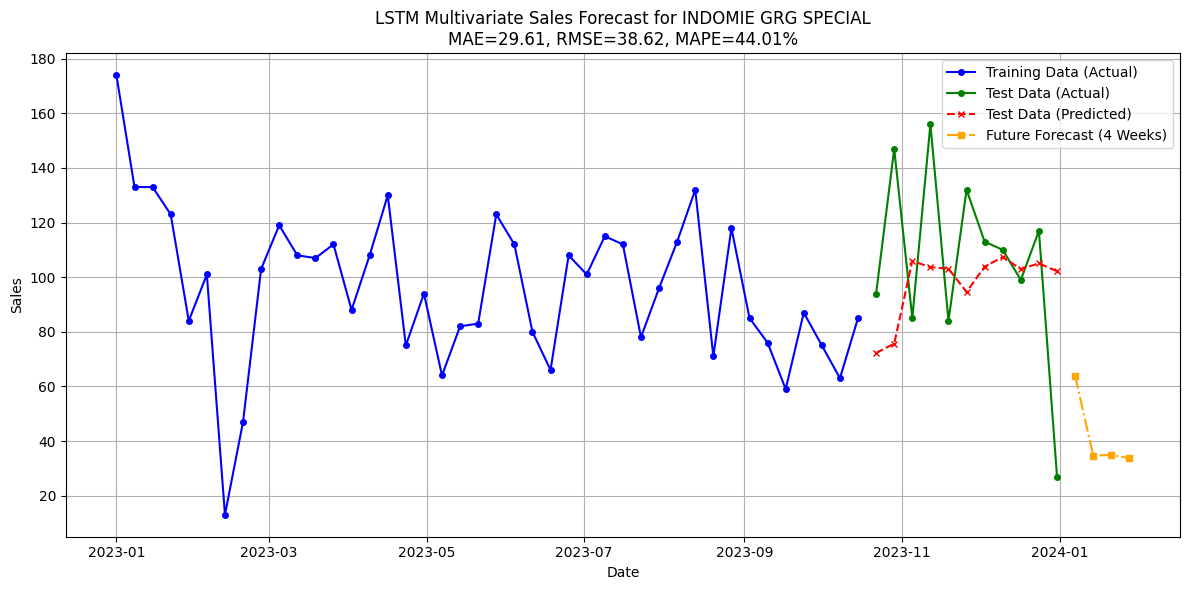


--- Memproses Produk: PUCUK HARUM TEH 350ML ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 21.17
  - RMSE: 25.66
  - MAPE: 259.05%


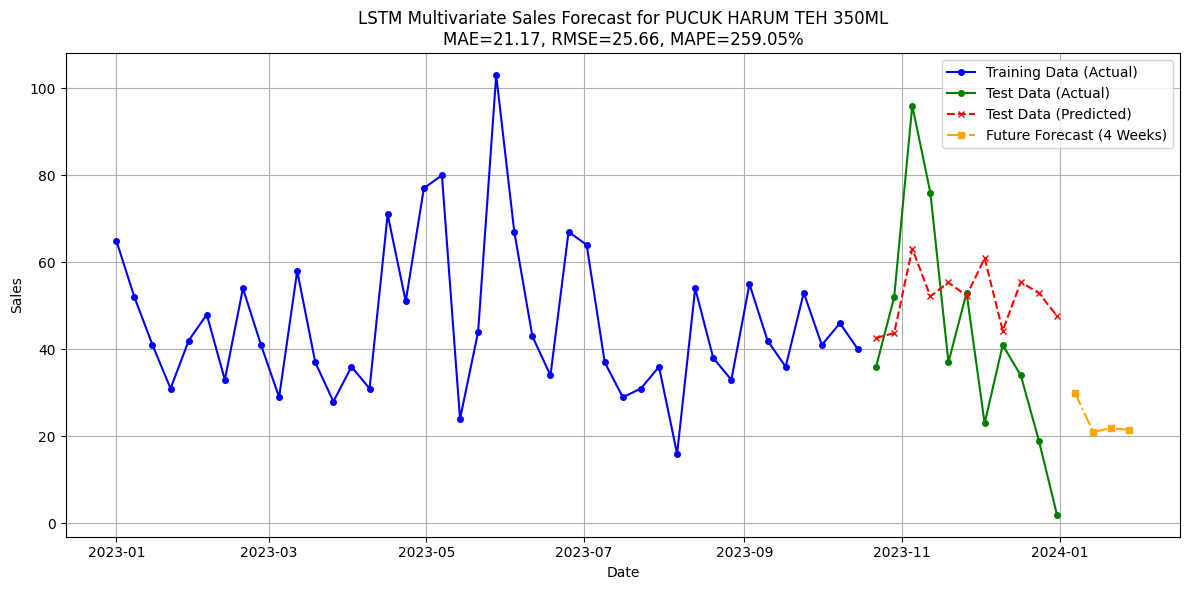


--- Memproses Produk: INDOMIE SOTO MIE ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 7.48
  - RMSE: 9.93
  - MAPE: 55.23%


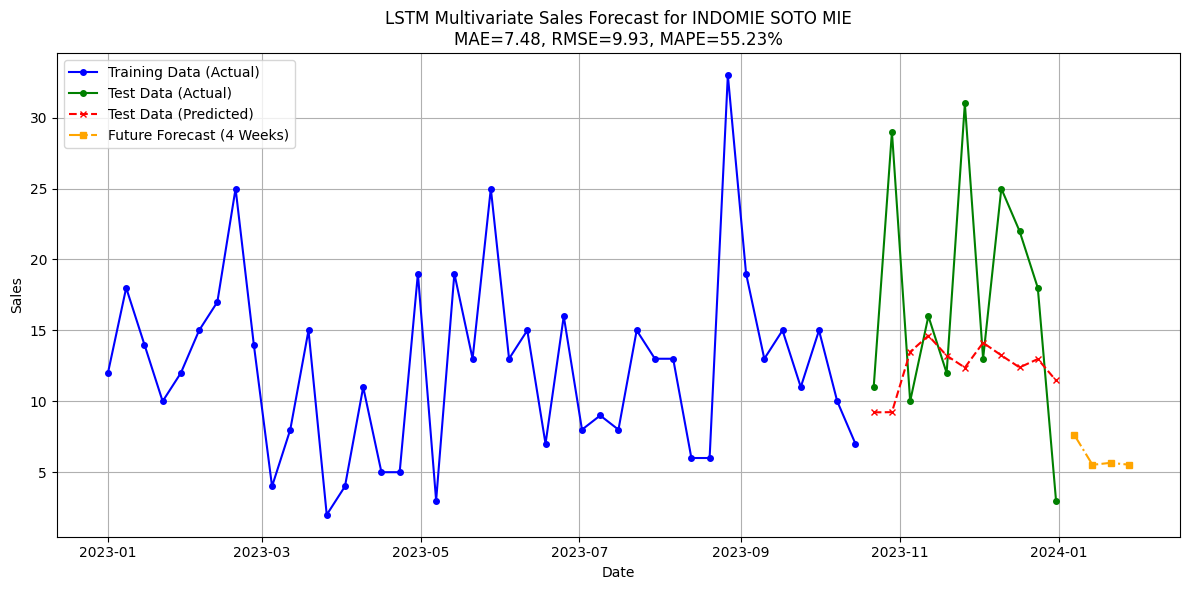


--- Memproses Produk: INDOMIE AYAM BAWANG ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 7.38
  - RMSE: 8.07
  - MAPE: 107.89%


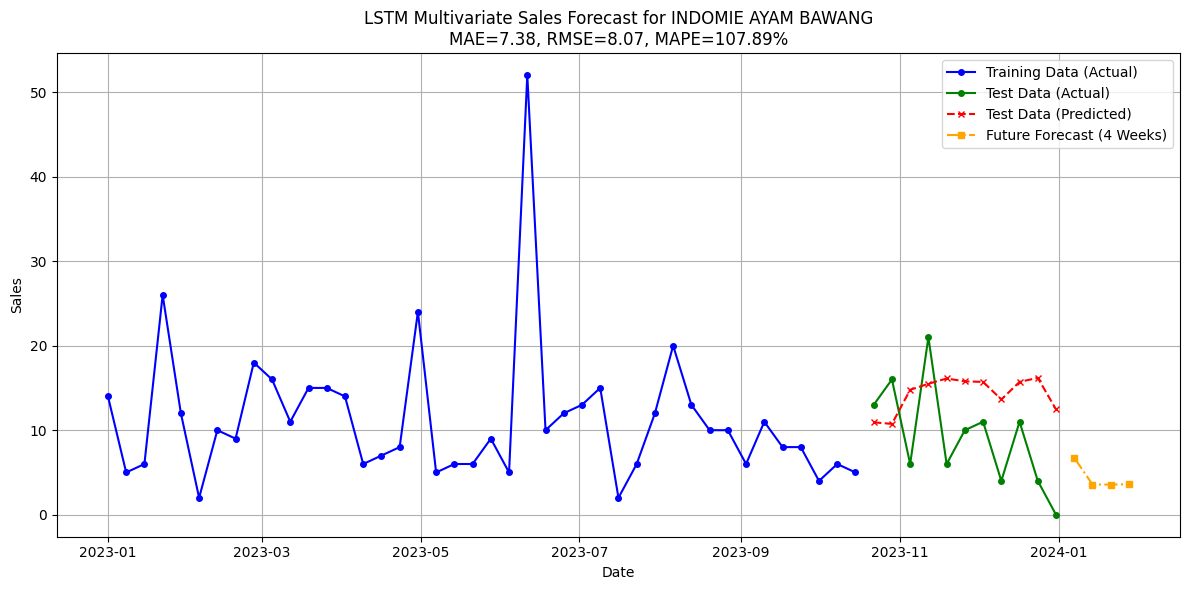


--- Memproses Produk: INDOMILK KID STR 115ML ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 7.84
  - RMSE: 9.70
  - MAPE: 54.63%


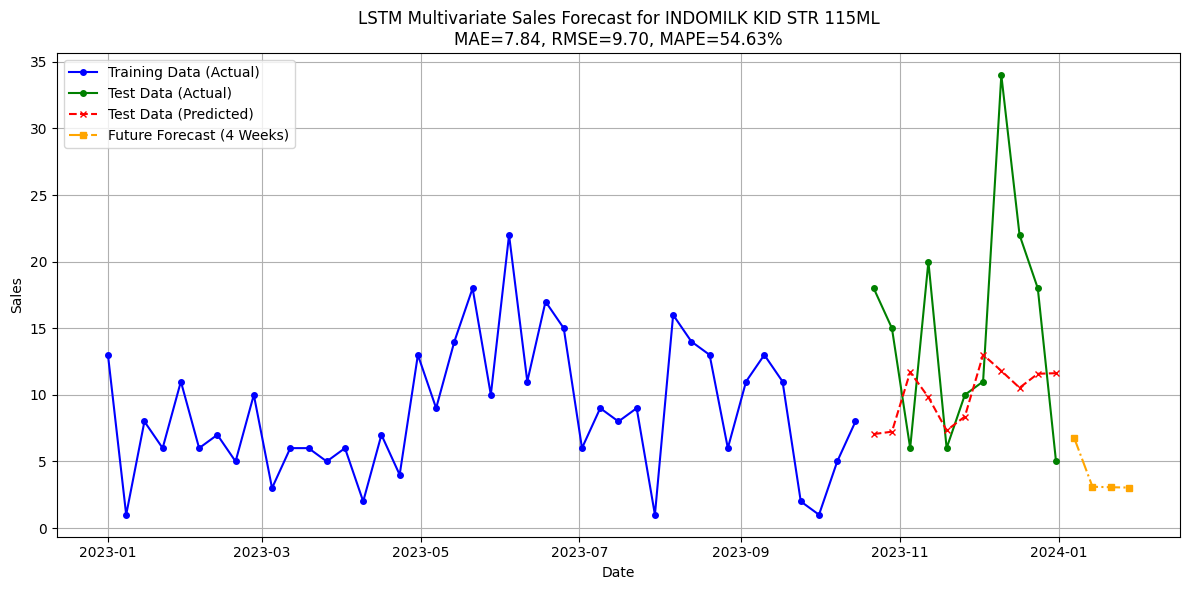


--- Memproses Produk: WALLS POPULAIRE STR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 3.61
  - RMSE: 4.40
  - MAPE: 30.62%


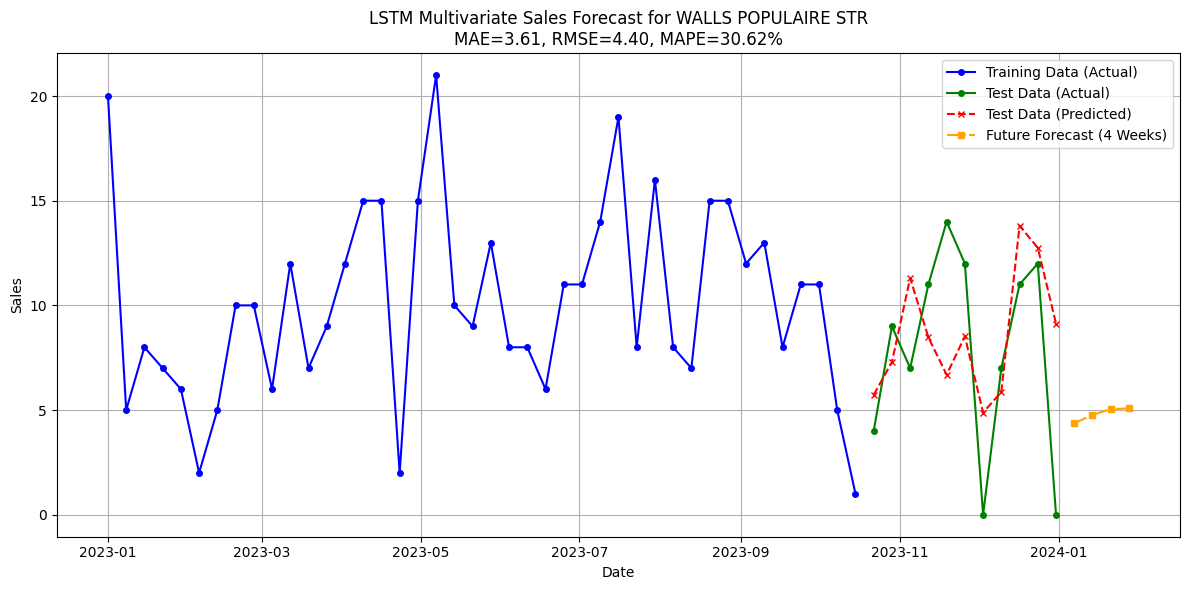


--- Memproses Produk: INDOMIE AYAM SPECIAL ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 4.92
  - RMSE: 5.63
  - MAPE: 43.83%


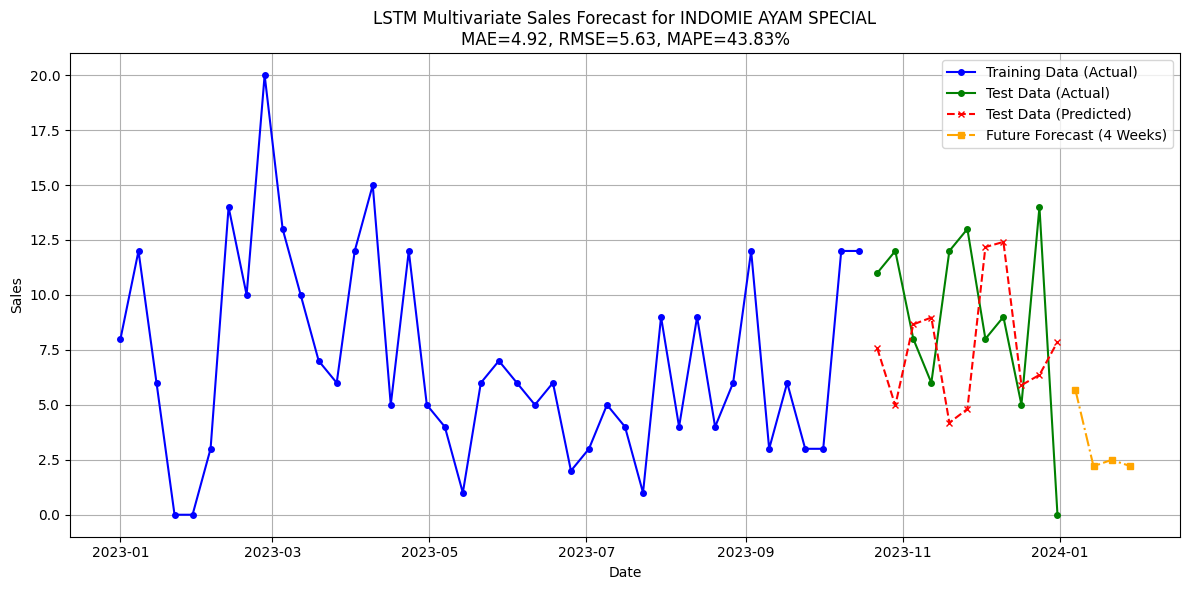


--- Memproses Produk: OREO SOFT CAKE 16GR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 4.40
  - RMSE: 5.07
  - MAPE: 114.93%


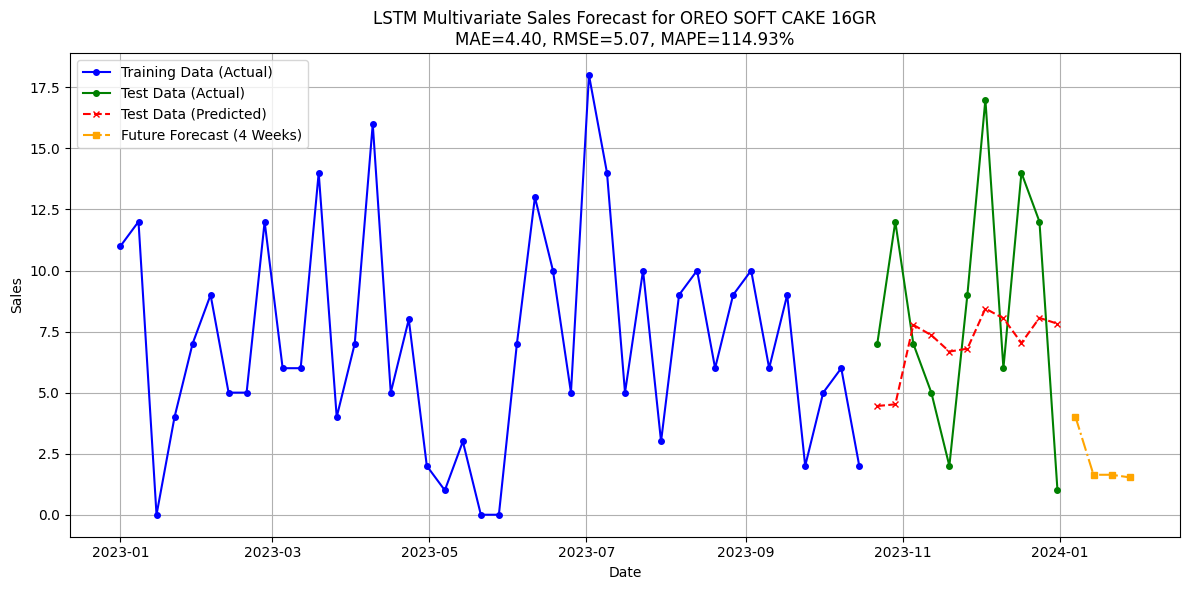


--- Memproses Produk: ROMA KELAPA 300GR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 3.74
  - RMSE: 4.17
  - MAPE: 141.15%


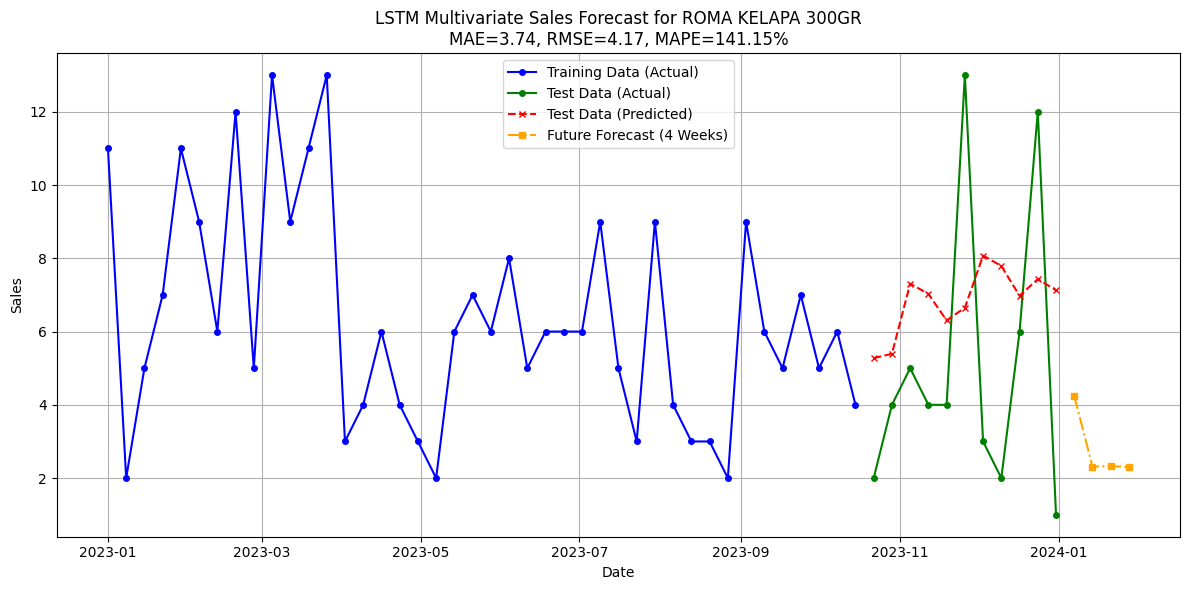


--- Memproses Produk: INDOMILK STR 190ML BTL ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 4.04
  - RMSE: 4.69
  - MAPE: 85.91%


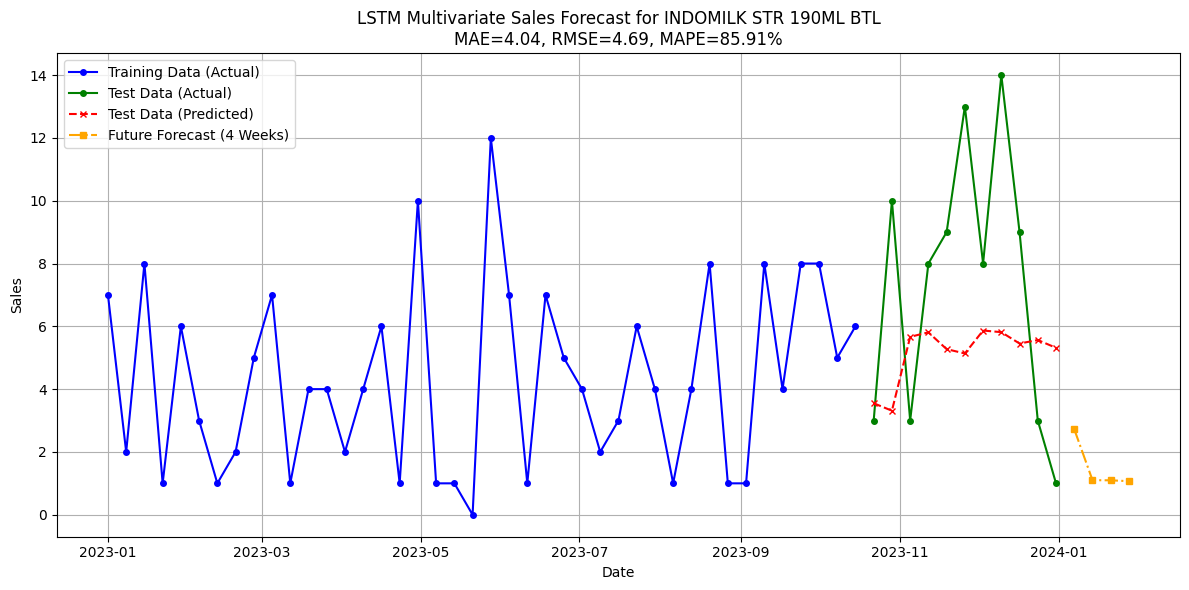


--- Memproses Produk: NUVO SOAP YLOW 72G ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 2.38
  - RMSE: 2.86
  - MAPE: 100.96%


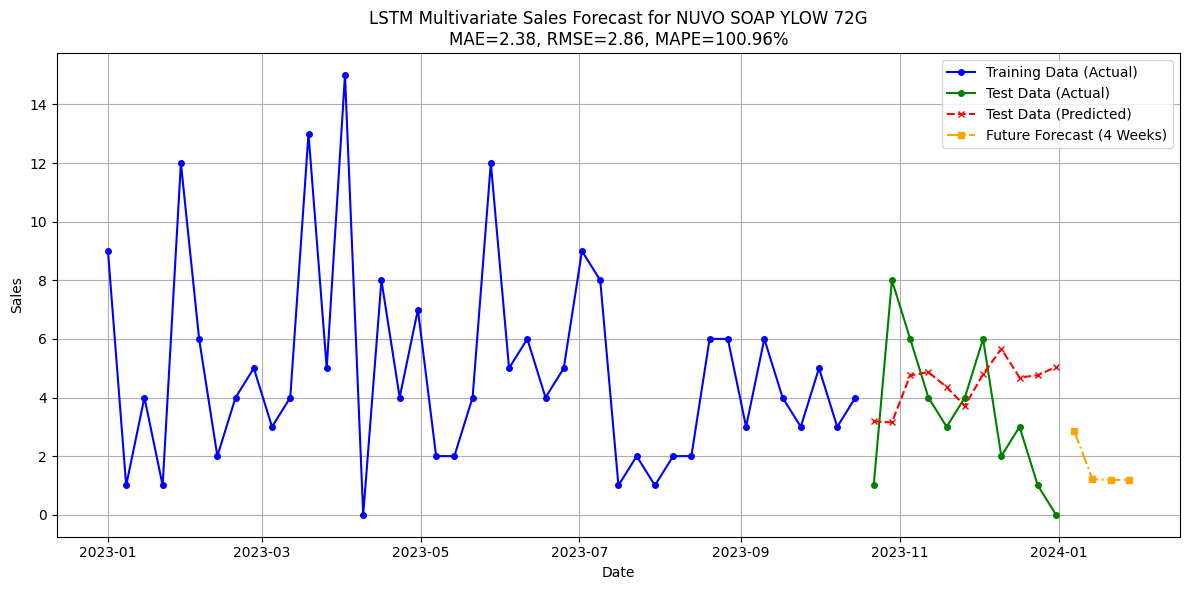


--- Memproses Produk: KRIPIK SGKG TURBO 180G ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 2.21
  - RMSE: 2.57
  - MAPE: 117.11%


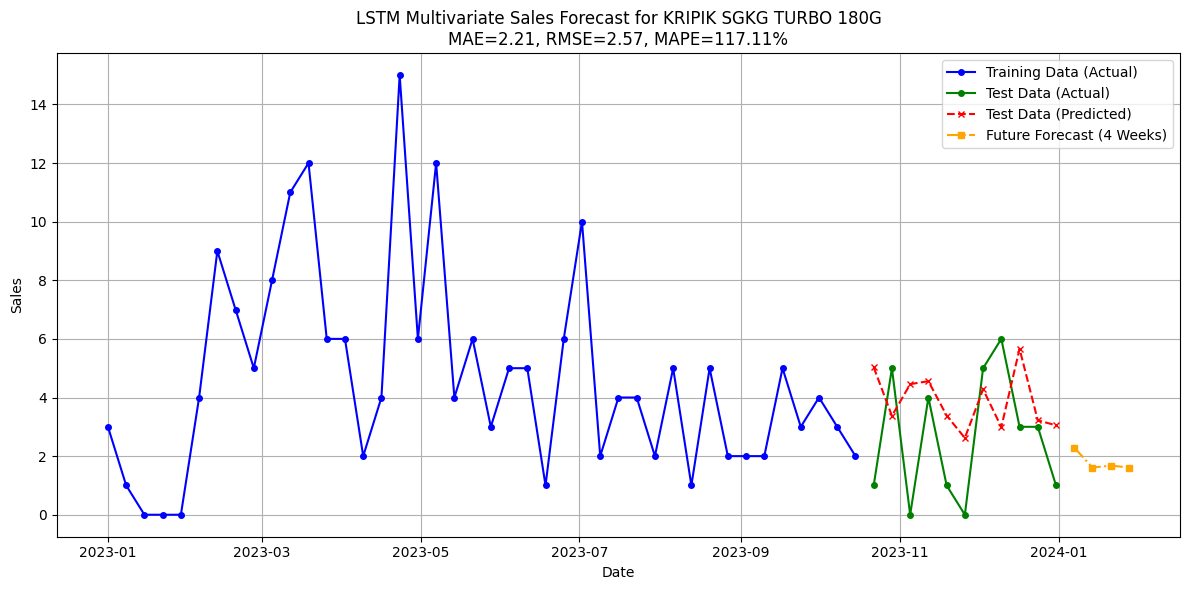


--- Memproses Produk: NUVO SOAP BLUE 72G ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 2.69
  - RMSE: 3.43
  - MAPE: 56.78%


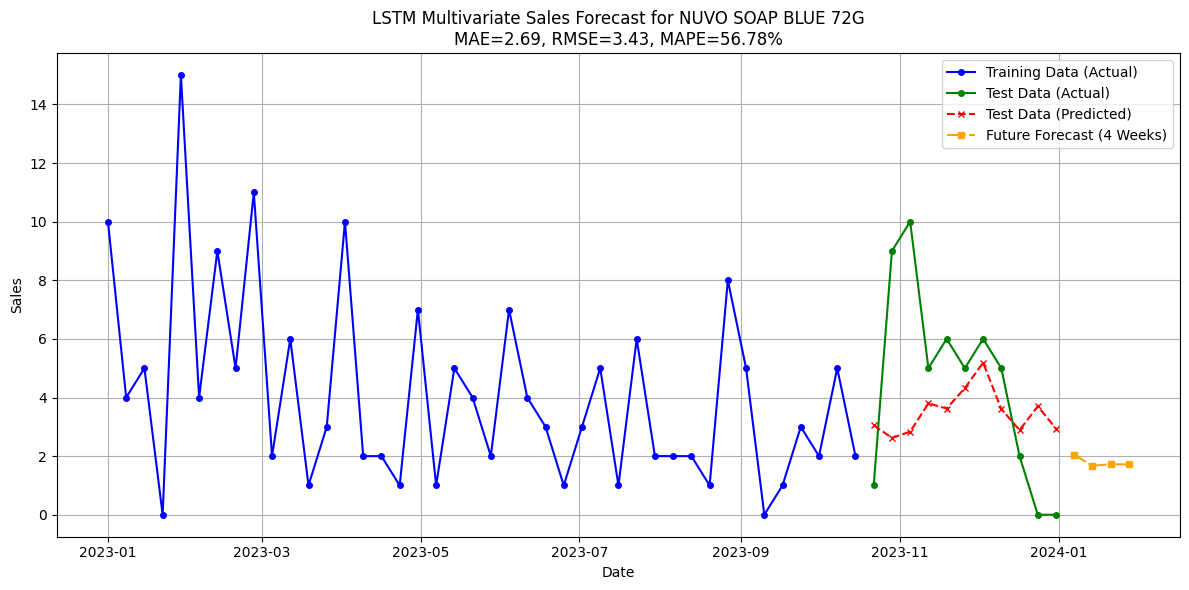


--- Memproses Produk: YA KOPI SPESIAL 60GR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 2.99
  - RMSE: 3.98
  - MAPE: 75.54%


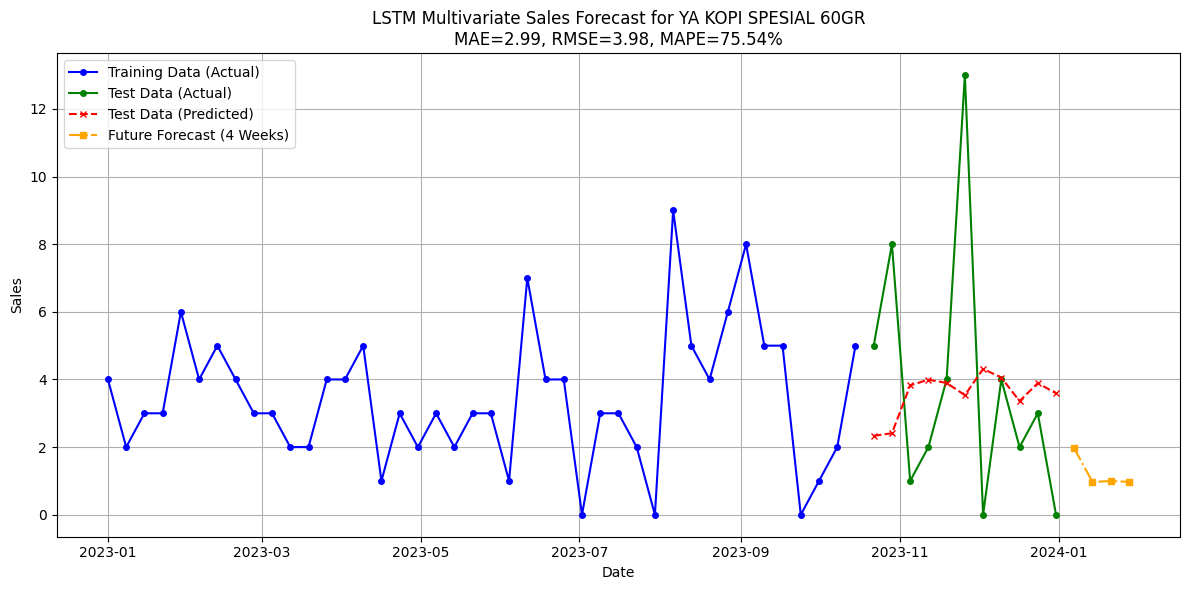



             PROSES FORECASTING DAN EVALUASI SELESAI             

--- Ringkasan Hasil Evaluasi Model (Produk dengan Akurasi Terbaik ke Terjelek) ---
                              MAE       RMSE        MAPE
WALLS POPULAIRE STR      3.613442   4.403232   30.619656
INDOMIE AYAM SPECIAL     4.916972   5.630118   43.830461
INDOMIE GRG SPECIAL     29.612485  38.617450   44.010238
INDOMILK KID STR 115ML   7.843378   9.696120   54.630696
INDOMIE SOTO MIE         7.475666   9.931732   55.227434
NUVO SOAP BLUE 72G       2.689703   3.431342   56.777574
YA KOPI SPESIAL 60GR     2.986744   3.977581   75.537236
INDOMILK STR 190ML BTL   4.039216   4.690373   85.905586
NUVO SOAP YLOW 72G       2.376899   2.857442  100.957300
INDOMIE AYAM BAWANG      7.383791   8.068955  107.894098
OREO SOFT CAKE 16GR      4.396469   5.074932  114.934069
KRIPIK SGKG TURBO 180G   2.212785   2.568013  117.112985
ROMA KELAPA 300GR        3.744866   4.171636  141.145006
PUCUK HARUM TEH 350ML   21.169441  25.659717  259.

In [16]:
# --- Pra-Pemrosesan Data ---
# Pastikan indeks adalah kolom 'TANGGAL'
if df_final.index.name == 'TANGGAL':
    df_final = df_final.reset_index()
elif 'TANGGAL' not in df_final.columns:
    df_final = df_final.reset_index()
    df_final.rename(columns={df_final.columns[0]: 'TANGGAL'}, inplace=True)

df_final['TANGGAL'] = pd.to_datetime(df_final['TANGGAL'])
product_columns = [col for col in df_final.columns if col != 'TANGGAL']

for col in product_columns:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')
    df_final[col] = df_final[col].fillna(0)
    df_final[col] = np.maximum(0, df_final[col])

# --- Fungsi untuk Menghitung Metrik ---
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    non_zero_indices = y_true != 0
    if np.sum(non_zero_indices) > 0:
        mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    else:
        mape = np.nan # Jika semua nilai aktual adalah 0, MAPE tidak terdefinisi

    return mae, rmse, mape

# --- Fungsi untuk Membuat Urutan Data untuk LSTM Multivariat ---
# 'data' kini adalah array 2D (samples, features)
# 'target_column_index' menunjukkan kolom mana yang akan diprediksi
def create_sequences_multivariate(data, look_back, target_column_index):
    X, y = [], []
    for i in range(len(data) - look_back):
        # X akan berisi semua fitur untuk periode look_back
        X.append(data[i:(i + look_back), :])
        # y akan berisi nilai target (dari target_column_index) pada langkah berikutnya
        y.append(data[i + look_back, target_column_index])
    return np.array(X), np.array(y)

# --- Hyperparameter LSTM ---
LOOK_BACK = 2 # Mengurangi LOOK_BACK karena data sangat sedikit
LSTM_UNITS = 50
EPOCHS = 100
BATCH_SIZE = 1 # Biasanya 1 untuk data deret waktu kecil
FORECAST_HORIZON = 4

# --- Persiapan Global untuk Scaling Multivariat ---
# Skala semua data produk sekaligus
all_product_data = df_final[product_columns].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_all_data = scaler.fit_transform(all_product_data)

# --- Persiapan untuk Forecasting ---
evaluation_results = {}
future_forecasts_data_list = []

train_size = int(len(df_final) * 0.8)
test_size = len(df_final) - train_size

print("="*80)
print("             MEMULAI FORECASTING DENGAN LSTM MULTIVARIATE DAN EVALUASI             ")
print("="*80)
print(f"Total data historis: {len(df_final)} titik.")
print(f"Ukuran data training (80%): {train_size} titik.")
print(f"Ukuran data testing (20%): {test_size} titik.")
print(f"Look-back window (jumlah langkah input): {LOOK_BACK}")
print("\n")

# Jumlah fitur (kolom produk)
n_features = len(product_columns)

# Loop untuk setiap produk (model terpisah, namun input multivariat)
for product_idx, product in enumerate(product_columns):
    print(f"\n--- Memproses Produk: {product} ---")

    # Ambil data yang diskalakan
    train_scaled = scaled_all_data[:train_size]
    # Data testing perlu menyertakan LOOK_BACK sebelumnya dari training untuk membentuk urutan
    test_scaled_with_history = scaled_all_data[train_size - LOOK_BACK:]

    # Buat urutan untuk training dan testing
    # X_train dan X_test sekarang akan memiliki dimensi (samples, look_back, n_features)
    X_train, y_train = create_sequences_multivariate(train_scaled, LOOK_BACK, product_idx)
    X_test, y_test_actual_scaled = create_sequences_multivariate(test_scaled_with_history, LOOK_BACK, product_idx)

    # Pastikan ada cukup data setelah look_back untuk training/testing
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"  Peringatan: Data tidak cukup untuk look_back ({LOOK_BACK}). Melewatkan produk.")
        evaluation_results[product] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
        future_forecasts_data_list.append(np.full(FORECAST_HORIZON, np.nan))
        continue

    # --- Bangun Model LSTM Multivariat ---
    model = Sequential()
    # input_shape sekarang adalah (LOOK_BACK, n_features)
    model.add(LSTM(LSTM_UNITS, activation='relu', input_shape=(LOOK_BACK, n_features)))
    model.add(Dense(1)) # Tetap memprediksi 1 nilai (untuk produk saat ini)
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                        validation_split=0.1, callbacks=[early_stopping])

    # --- Prediksi pada Data Testing ---
    y_pred_scaled = model.predict(X_test, verbose=0)

    # --- Inverse Transform Prediksi dan Aktual ---
    # Karena scaler fit pada semua fitur, kita perlu membuat dummy array untuk inverse transform
    # untuk mendapatkan nilai unscaled yang benar untuk kolom target
    dummy_pred_array = np.zeros((len(y_pred_scaled), n_features))
    dummy_pred_array[:, product_idx] = y_pred_scaled.flatten()
    y_pred_unscaled = scaler.inverse_transform(dummy_pred_array)[:, product_idx]

    dummy_actual_array = np.zeros((len(y_test_actual_scaled), n_features))
    dummy_actual_array[:, product_idx] = y_test_actual_scaled.flatten()
    y_test_actual_unscaled = scaler.inverse_transform(dummy_actual_array)[:, product_idx]

    y_pred_unscaled[y_pred_unscaled < 0] = 0 # pastikan tidak ada nilai negatif

    # --- Evaluasi Metrik ---
    mae, rmse, mape = calculate_metrics(y_test_actual_unscaled, y_pred_unscaled)

    print(f"  - MAE: {mae:.2f}")
    print(f"  - RMSE: {rmse:.2f}")
    if pd.isna(mape):
        print(f"  - MAPE: N/A (Semua nilai aktual adalah 0 di periode testing)")
    else:
        print(f"  - MAPE: {mape:.2f}%")

    evaluation_results[product] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

    # --- Prediksi Masa Depan (Forecasting) ---
    # Ambil look_back terakhir dari data keseluruhan yang diskalakan sebagai input awal
    current_input = scaled_all_data[-LOOK_BACK:].reshape(1, LOOK_BACK, n_features)
    product_future_forecast_scaled = []

    # Kita perlu array yang merepresentasikan 'keadaan' fitur terakhir
    # Ini akan diperbarui dengan prediksi produk saat ini
    last_known_features_scaled = scaled_all_data[-1, :].copy()

    for _ in range(FORECAST_HORIZON):
        # Lakukan prediksi untuk produk saat ini
        predicted_scaled_target = model.predict(current_input, verbose=0)[0, 0]
        product_future_forecast_scaled.append(predicted_scaled_target)

        # Perbarui nilai produk yang baru diprediksi di array last_known_features_scaled
        last_known_features_scaled[product_idx] = predicted_scaled_target

        # Bentuk input baru untuk langkah berikutnya: geser look_back ke depan
        # dan tambahkan vektor fitur terbaru (dengan prediksi yang baru)
        new_feature_vector = last_known_features_scaled.reshape(1, 1, n_features)
        current_input = np.concatenate((current_input[:, 1:, :], new_feature_vector), axis=1)

    # Inverse Transform prediksi masa depan
    dummy_future_pred_array = np.zeros((len(product_future_forecast_scaled), n_features))
    dummy_future_pred_array[:, product_idx] = np.array(product_future_forecast_scaled).flatten()
    product_future_forecast_unscaled = scaler.inverse_transform(dummy_future_pred_array)[:, product_idx]
    product_future_forecast_unscaled[product_future_forecast_unscaled < 0] = 0 # pastikan tidak ada nilai negatif

    future_forecasts_data_list.append(product_future_forecast_unscaled.flatten())

    # --- Visualisasi ---
    plt.figure(figsize=(12, 6))
    
    # Plot data historis (training dan testing)
    plt.plot(df_final['TANGGAL'].iloc[:train_size], df_final[product].iloc[:train_size], 
             label='Training Data (Actual)', color='blue', marker='o', markersize=4, linestyle='-')
    
    # Tanggal aktual untuk plot test data harus dimulai dari indeks train_size
    actual_test_dates = df_final['TANGGAL'].iloc[train_size : train_size + len(y_test_actual_unscaled)]
    
    plt.plot(actual_test_dates, y_test_actual_unscaled, 
             label='Test Data (Actual)', color='green', marker='o', markersize=4, linestyle='-')
    
    # Plot prediksi pada periode testing
    plt.plot(actual_test_dates, y_pred_unscaled.flatten(), 
             label='Test Data (Predicted)', color='red', marker='x', markersize=4, linestyle='--')
    
    # Plot prediksi masa depan
    future_dates = pd.date_range(start=df_final['TANGGAL'].iloc[-1] + pd.Timedelta(weeks=1), 
                                 periods=FORECAST_HORIZON, freq='W')
    plt.plot(future_dates, product_future_forecast_unscaled.flatten(), 
             label=f'Future Forecast ({FORECAST_HORIZON} Weeks)', color='orange', marker='s', markersize=4, linestyle='-.')
    
    plt.title(f'LSTM Multivariate Sales Forecast for {product}\nMAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Buat DataFrame untuk prediksi masa depan (setelah semua loop selesai)
last_historical_date_actual_df = df_final['TANGGAL'].iloc[-1]
future_dates_df_index = pd.date_range(start=last_historical_date_actual_df + pd.Timedelta(weeks=1), periods=FORECAST_HORIZON, freq='W')
future_forecasts_df = pd.DataFrame(np.array(future_forecasts_data_list).T, columns=product_columns, index=future_dates_df_index)
future_forecasts_df.index.name = 'TANGGAL'


print("\n")
print("="*80)
print("             PROSES FORECASTING DAN EVALUASI SELESAI             ")
print("="*80)

# --- 4. Ringkasan Hasil Evaluasi Model dan Prediksi ---
print("\n--- Ringkasan Hasil Evaluasi Model (Produk dengan Akurasi Terbaik ke Terjelek) ---")

eval_df_summary = pd.DataFrame.from_dict(evaluation_results, orient='index')
# Urutkan berdasarkan MAPE, jika MAPE NaN, urutkan berdasarkan MAE
eval_df_summary_sorted = eval_df_summary.sort_values(by=['MAPE', 'MAE'], ascending=True, na_position='last')

print(eval_df_summary_sorted.to_string())

# --- Tambahkan Ringkasan Metrik Keseluruhan di sini ---
print("\n--- Performa Model Keseluruhan (Rata-rata Lintas Produk) ---")
# Hanya hitung rata-rata untuk produk yang tidak memiliki NaN di MAPE/MAE
valid_eval_df = eval_df_summary_sorted.dropna(subset=['MAE', 'RMSE']) # MAPE bisa jadi NaN jika semua aktual 0
overall_mae = valid_eval_df['MAE'].mean()
overall_rmse = valid_eval_df['RMSE'].mean()
overall_mape = valid_eval_df['MAPE'].mean()

print(f"Average MAE:  {overall_mae:.2f}")
print(f"Average RMSE: {overall_rmse:.2f}")
if pd.isna(overall_mape):
    print("Average MAPE: N/A (Satu atau lebih produk memiliki semua nilai aktual nol di test set)")
else:
    print(f"Average MAPE: {overall_mape:.2f}%")
# --- Akhir Penambahan ---

print(f"\n--- Prediksi Penjualan untuk {FORECAST_HORIZON} Minggu Ke Depan ---")
print(future_forecasts_df.to_string())

print("\n--- Catatan Penting ---")
print("1. Akurasi model sangat terbatas karena jumlah data historis yang SANGAT SEDIKIT (hanya 4 titik).")
print("2. 'MAPE: N/A' menunjukkan bahwa semua nilai aktual di periode testing adalah 0.")
print("3. Model LSTM multivariat menggunakan data semua produk sebagai input untuk memprediksi satu produk.")
print("4. Prediksi masa depan untuk satu produk dipengaruhi oleh nilai prediksi/aktual produk lain.")
print("5. Untuk hasil yang lebih andal, diperlukan data historis yang JAUH lebih banyak (minimal beberapa tahun) dan lebih bervariasi.")
print("6. Look-back window disesuaikan menjadi 2 agar ada cukup data untuk training/testing.")